In [9]:
###############################################################################################################
# version 4.
# Procesa las estaciones disponibles en csv de entrada y calcula los modelos de series temporales de cada una.
# Según los "n" días previos (ventana de "n" valores), predice el día siguiente del atributo seleccionado.
###############################################################################################################

In [10]:
# librerías necesarias

import pandas as pd
import numpy as np
import plotly 
import plotly.express as px
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

np.random.seed(12345)

# Configuración general de las figuras que representaremos
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 10)

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
path = '/content/drive/MyDrive/datoscsv/'
dfCompleto = pd.read_csv(path + 'airWeather_2013-2019_v3.csv', sep=';', index_col='FECHA', parse_dates=['FECHA'])

# Recuperar la fecha como campo
dfCompleto.insert(0, 'FECHA', dfCompleto.index.strftime('%Y-%m-%d'))

In [13]:
def procesar_atributo(atributo, cod_esta, nom_esta, df):
  print(f'Procesando atributo {atributo}')
  
  # eliminar filas que no tengan el atributo que queremos procesar
  df = df[df[atributo].notnull()]
  # Modelo LSMT
  # Definir el número de días de la ventana de entrada (días previos a considerar para la predicción)
  n = 30
  # Definir número de epoch máximo para entrenamiento
  max_epochs = 50
  # Vamos a coger del 2013 al 2018 para entrenamiento y los datos del 2019 para testear
  # Para poder introducir los datos en una red neuronal hay que transformarlos, ya que solo funciona con arrays
  df2 = df[[atributo]]
  train = df2[:'2018']    # guardar desde fecha más antigua hasta final de 2018
  test = train.iloc[-n:]  # guardar los "n" últimos dias del 2018
  test = test.append(df2['2019'], ignore_index=False) # añadir a los "n" días del 2018 + el 2019 completo  
  
  train[atributo].plot(legend=True)
  test[atributo].plot(legend=True)

  plt.legend(['Train (2013-2018)', 'Test (2019)'])
  plt.show()

  # Normalización
  sc = MinMaxScaler(feature_range=(0,1))
  train_scaled = sc.fit_transform(train)

  # Estructura datos entrada
  # Hay que crear una estructura de datos para indicarle a la red lo que tiene que recordar 
  # y poder hacer una predección en base a datos anteriores
  X_train = []
  y_train = []

  # Estructura de datos con "n" pasos y un valor de salida
  # "n" timesteps significa que para un día dado la red es capaz de mirar los "n" días anteriores:
  # "n" valores anteriores al día actual y en base a esa información predice el valor futuro 
  for i in range(n,len(train_scaled)):
      # X: para cada día hacemos un bloque correspondiente al valor de los "n" días anteriores
      X_train.append(train_scaled[i-n:i,0])
      # Y: el valor del día
      y_train.append(train_scaled[i,0])

  # Tenemos una matriz donde cada fila contiene "n" columnas correspondientes a los "n" días anteriores
  X_train, y_train = np.array(X_train), np.array(y_train)

  # Reshape X_train para que se ajuste al modelo en Keras
  # añadiendo una nueva dimensión 
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
  X_train.shape

  # Modelo
  # Creamos un modelo secuencial al que iremos añadiendo capas, que pueden ser:
  # Dense: Capa de neuronas artificiales
  # LSTM: Capa de neuronas con capacidad de memoria
  # Dropout: Es una técnica de regularización que elimina conexiones neuronales para evitar el sobreajuste, de esta forma se evita que el algoritmo memorice los datos en vez de aprender de ellos.
  # Antes de crear la Red LSTM debemos reajustar los sets que acabamos de obtener, para indicar que cada ejemplo de entrenamiento a la entrada del modelo será un vector de "n" x 1.
  # Para el caso de cada una de las salidas (almacenadas en y_train) debemos simplemente especificar que su tamaño será igual a 1, que corresponde al único valor predicho por la red.
  # Definimos el tamaño de los datos de entrada y de salida
  dim_entrada = (X_train.shape[1],1)
  dim_salida = 1

  modelo = Sequential()
  # Añadimos la primera capa y especificamos el número de neuromas (50) y el tamaño de cada dato de entrada
  modelo.add(LSTM (units=50, return_sequences=True, input_shape=dim_entrada))
  modelo.add(Dropout(0.2))
  # Añadimos la segunda capa
  modelo.add(LSTM (units=50, return_sequences=True))
  modelo.add(Dropout(0.2))
  # Añadimos la tercera capa
  modelo.add(LSTM (units=50, return_sequences=True))
  modelo.add(Dropout(0.2))
  # Añadimos la cuarta capa
  modelo.add(LSTM (units=50))
  modelo.add(Dropout(0.2))
  # Añadimos la capa de salida (Dense) y especificamos que el campo de salida es igual a 1
  modelo.add(Dense(units=dim_salida))

  # Compilación
  # El optimizador se encarga de optimizar y actualizar los pesos de la red. Usaremos el algoritmo adam que es el que mejores resultados nos aporta.
  # loss: Cuando la red hace una predicción coge el valor real y lo compará con la predicción. Para calcular el error de predicción, se utilizará el método error cuadrático medio.
  
  # Compilamos el modelo definiendo la función de error (loss) y el método que se usa para minimizarla (optimizer)
  modelo.compile(optimizer='adam', loss='mean_squared_error')

  # Entrenamiento
  # epochs: Especificamos las veces que la red propagara el error hacia atrás para aprender y hacer mejores predicciones. Es la cantidad de veces que la red realizará una predicción y propagara hacia atrás el error, para aprender de él y hacer mejores predicciones
  # batch_size: Para este proceso de predicción, corrección y propagación hacia atrás, no lo haremos con un solo bloque de datos, si no de 32. Si no el entrenamiento sería demasiado pesado para la red, el tener que actualizar los pesos a cada dato. Vamos actualizando los pesos con bloques de datos.

  # Entrenamos el modelo con max_epochs (iteraciones) y batch_size=32 (lotes de 32 datos)

  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

  modelo.fit(X_train,y_train,epochs=max_epochs, batch_size=32, callbacks=[callback])

  # Predicciones
  # Hay que preparar los datos como en el caso de train, esto es, hacemos bloques de "n" días para predecir el valor de la acción en el siguiente día.
  test_scaled = sc.fit_transform(test)

  X_test = []
  for i in range(n,len(test_scaled)):
      X_test.append(test_scaled[i-n:i,0])

  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

  # Realizamos la prediccion y aplicamos normalización inversa para que esté en escala real
  prediccion = modelo.predict(X_test)
  prediccion = sc.inverse_transform(prediccion)

  print(len(prediccion))

  # prediccion
  # Visualización del resultado
  resultados = test.tail(len(test)-n)

  # SANTI: Ver datos
  print(resultados)



  resultados['Prediccion'] = prediccion

  resultados

  plt.plot(train[atributo], color='green')
  plt.plot(resultados[atributo], color='red', label='Valor real de Temp')
  plt.plot(resultados['Prediccion'], color='blue', label='Predicción de Temp')
  # plt.ylim(1.1 * np.min(resultados['Prediccion'])/2, 1.1 * np.max(resultados['Prediccion']))
  plt.xlabel('Tiempo')
  plt.ylabel('Valor de ' + atributo)
  plt.legend()
  plt.show()

  plt.plot(resultados[atributo], color='red', label='Valor real de ' + atributo)
  plt.plot(resultados['Prediccion'], color='blue', label='Predicción de ' + atributo)
  plt.xlabel('Tiempo')
  plt.ylabel('Valor de ' + atributo)
  plt.legend()
  plt.show()

  from sklearn.metrics import mean_absolute_error

  # Error absoluto medio en la predicción
  print(mean_absolute_error(resultados['Prediccion'], resultados[atributo]))


  


In [14]:
def procesar_estacion(cod_esta, nom_esta, df):
  print(f'Procesando estacion {cod_esta} {nom_esta}')
  # seleccionar los datos de la estacion a procesar
  df = df[df['COD_ESTACION']==cod_esta]
  # procesar los atributos de la estación
  procesar_atributo('O3', cod_esta, nom_esta, df)

[46250043 46250046 46250047 46250048]
['VALÈNCIA  VIVERS' 'VALÈNCIA  POLITÈCNIC' 'VALÈNCIA  AVD. FRANCIA'
 'VALÈNCIA  MOLÍ DEL SOL']
Procesando estacion 46250043 VALÈNCIA  VIVERS
Procesando atributo O3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  app.launch_new_instance()


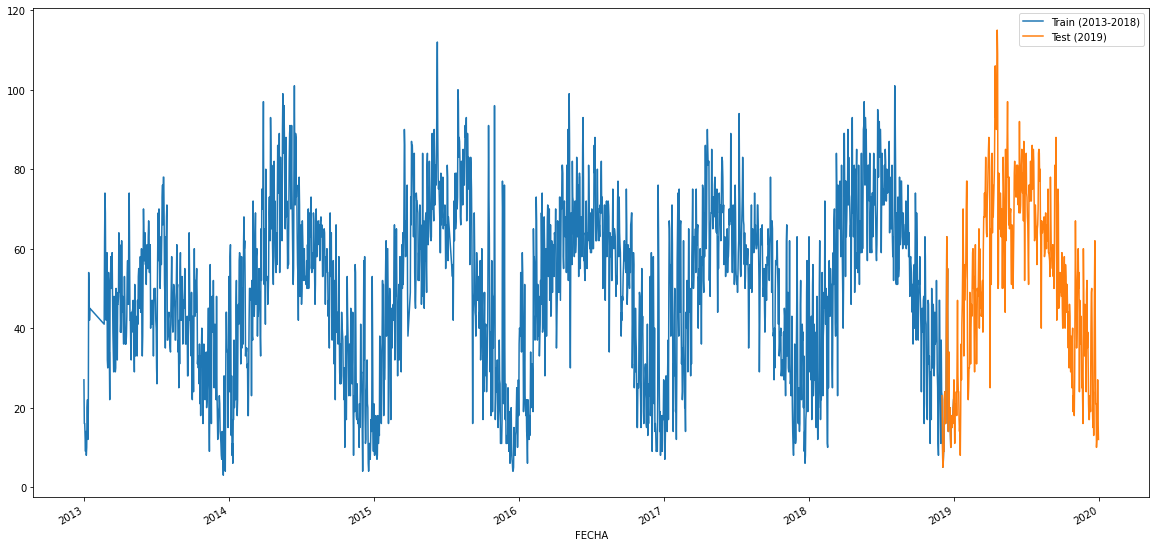

Epoch 1/50
66/66 [==============================] - 13s 77ms/step - loss: 0.0347
Epoch 2/50
66/66 [==============================] - 5s 72ms/step - loss: 0.0196
Epoch 3/50
66/66 [==============================] - 5s 76ms/step - loss: 0.0193
Epoch 4/50
66/66 [==============================] - 5s 74ms/step - loss: 0.0196
Epoch 5/50
66/66 [==============================] - 5s 77ms/step - loss: 0.0191
Epoch 6/50
66/66 [==============================] - 5s 76ms/step - loss: 0.0181
Epoch 7/50
66/66 [==============================] - 5s 75ms/step - loss: 0.0189
Epoch 8/50
66/66 [==============================] - 5s 73ms/step - loss: 0.0187
Epoch 9/50
66/66 [==============================] - 5s 76ms/step - loss: 0.0178
Epoch 10/50
66/66 [==============================] - 5s 71ms/step - loss: 0.0176
Epoch 11/50
66/66 [==============================] - 5s 76ms/step - loss: 0.0177
Epoch 12/50
66/66 [==============================] - 5s 75ms/step - loss: 0.0170
Epoch 13/50
66/66 [=================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


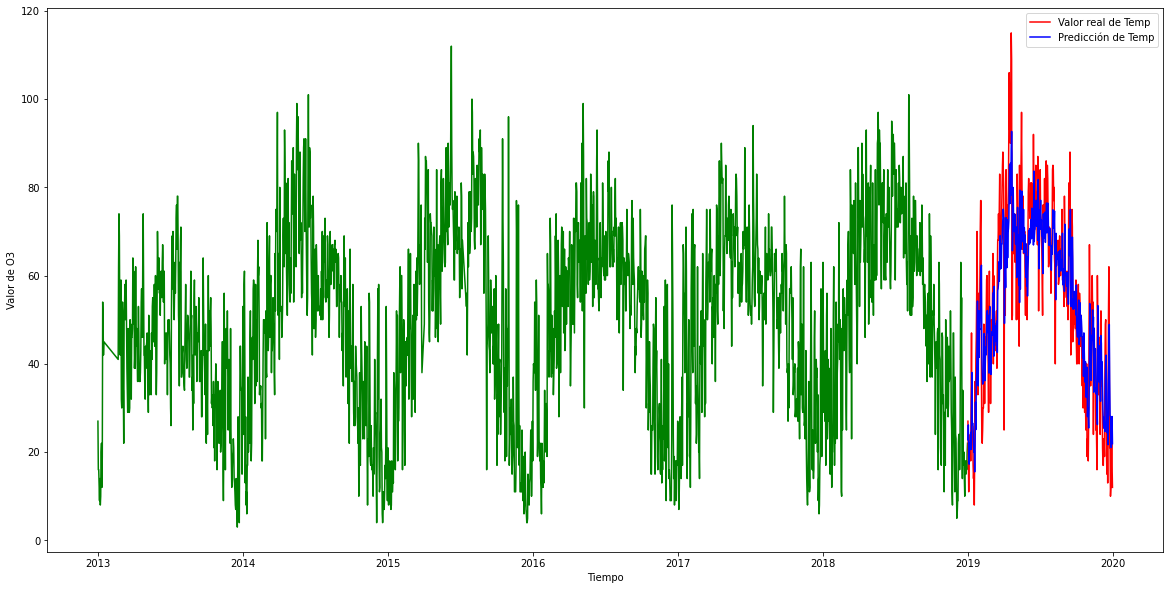

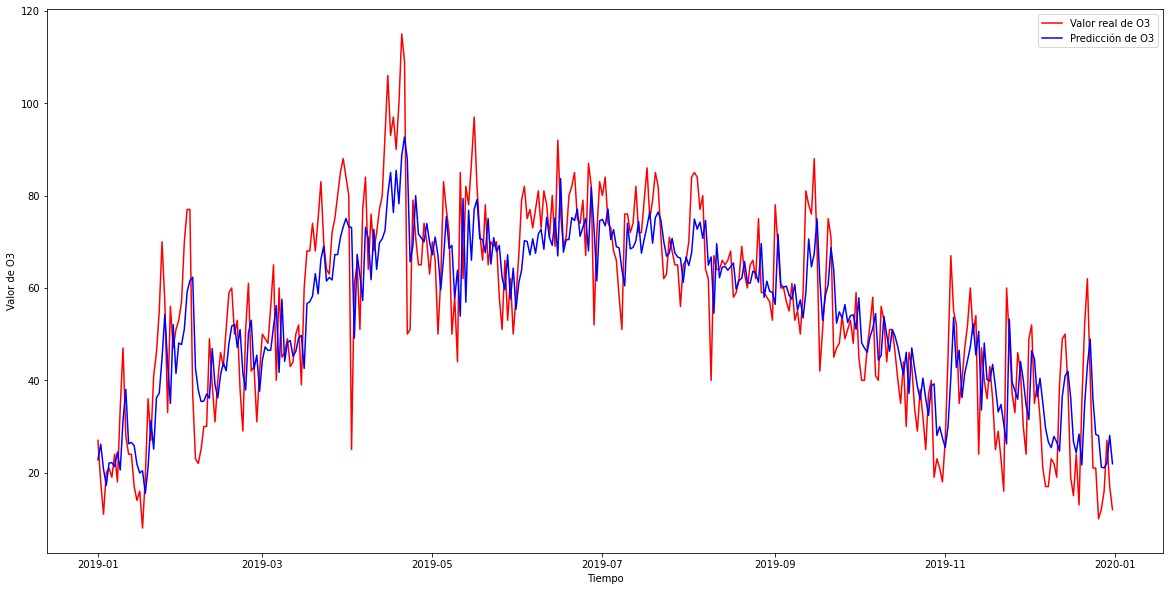

8.770685141053919
Procesando estacion 46250046 VALÈNCIA  POLITÈCNIC
Procesando atributo O3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  app.launch_new_instance()


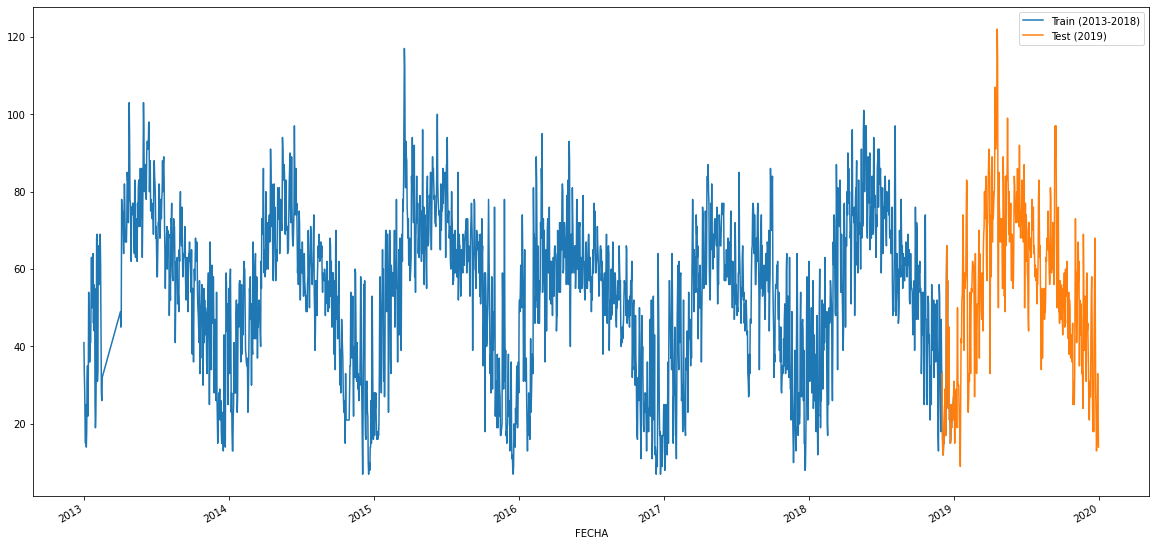

Epoch 1/50
66/66 [==============================] - 14s 76ms/step - loss: 0.0322
Epoch 2/50
66/66 [==============================] - 5s 77ms/step - loss: 0.0174
Epoch 3/50
66/66 [==============================] - 5s 80ms/step - loss: 0.0169
Epoch 4/50
66/66 [==============================] - 5s 79ms/step - loss: 0.0164
Epoch 5/50
66/66 [==============================] - 5s 79ms/step - loss: 0.0168
Epoch 6/50
66/66 [==============================] - 5s 79ms/step - loss: 0.0163
Epoch 7/50
66/66 [==============================] - 5s 81ms/step - loss: 0.0159
Epoch 8/50
66/66 [==============================] - 5s 79ms/step - loss: 0.0152
Epoch 9/50
66/66 [==============================] - 5s 82ms/step - loss: 0.0149
Epoch 10/50
66/66 [==============================] - 5s 81ms/step - loss: 0.0147
Epoch 11/50
66/66 [==============================] - 5s 78ms/step - loss: 0.0147
Epoch 12/50
66/66 [==============================] - 5s 77ms/step - loss: 0.0150
Epoch 13/50
66/66 [=================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


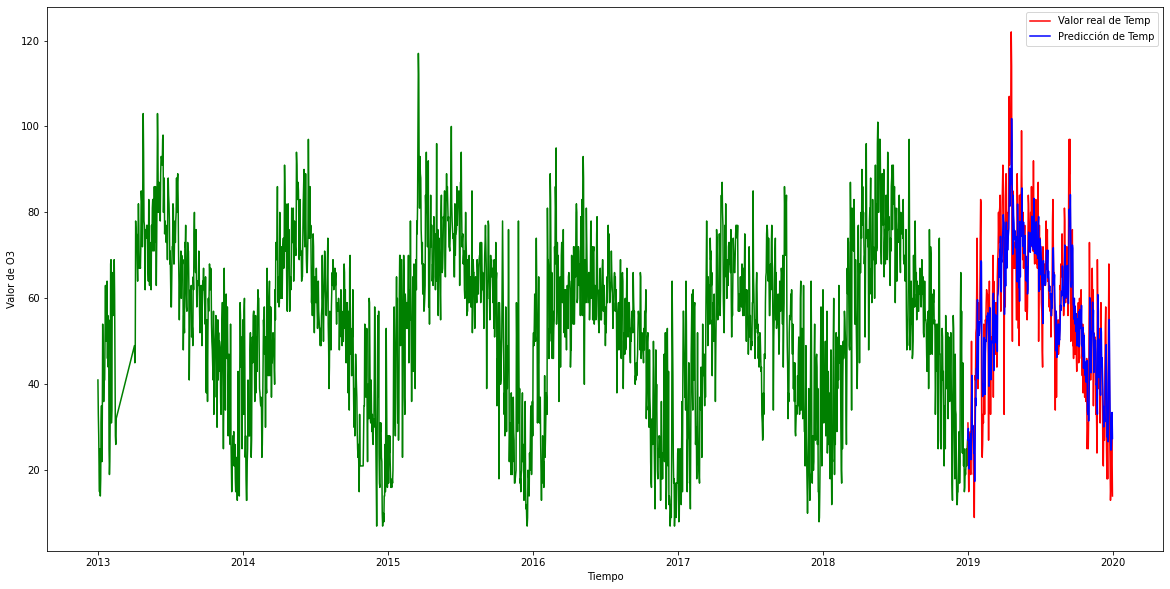

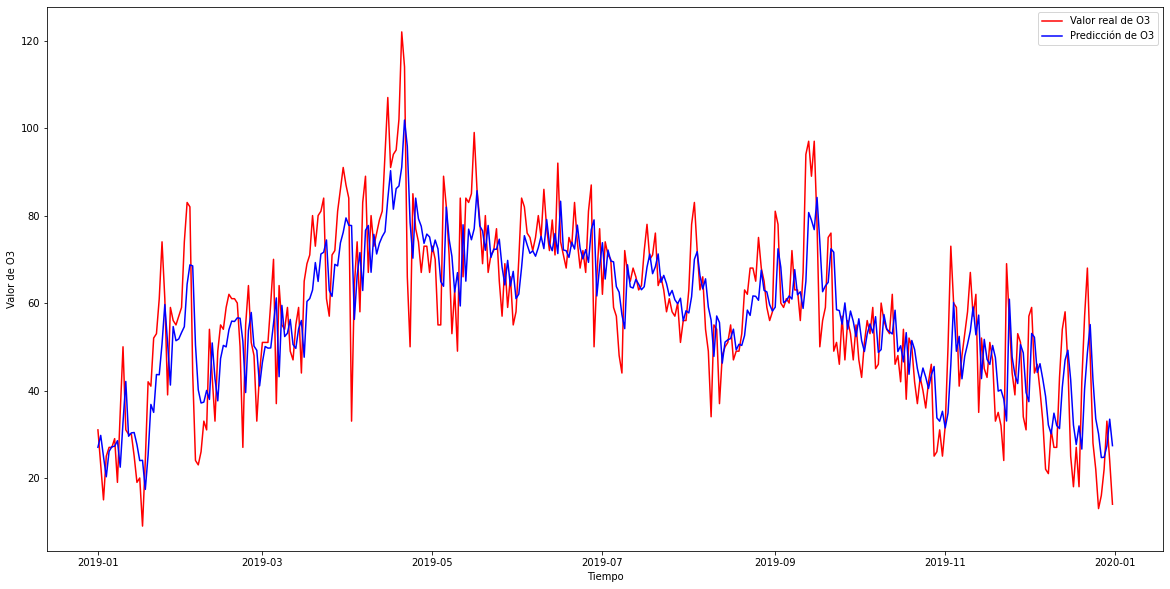

8.677388188610339
Procesando estacion 46250047 VALÈNCIA  AVD. FRANCIA
Procesando atributo O3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  app.launch_new_instance()


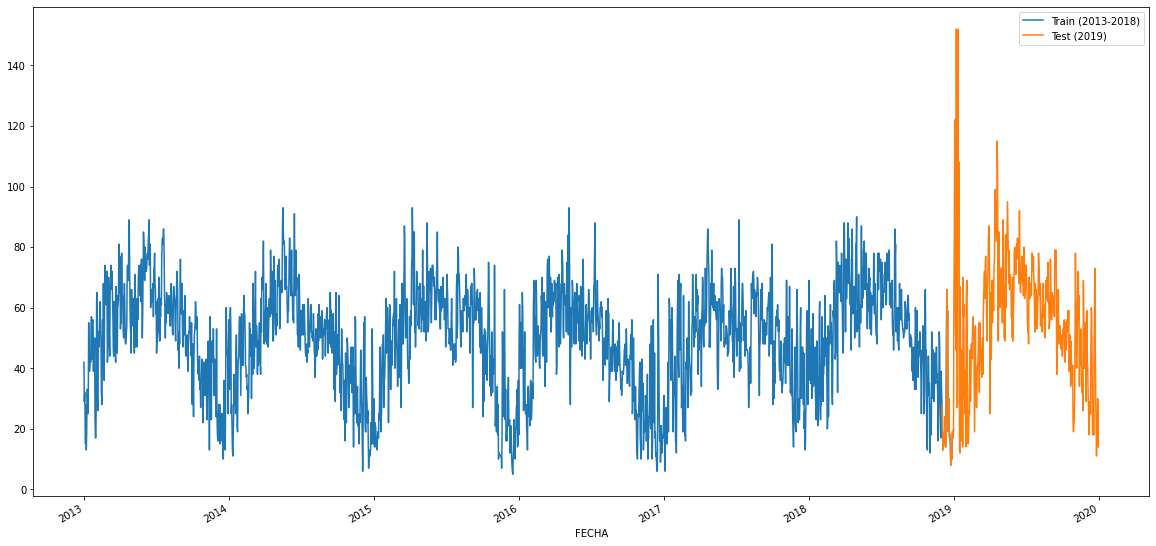

Epoch 1/50
68/68 [==============================] - 15s 82ms/step - loss: 0.0403
Epoch 2/50
68/68 [==============================] - 6s 84ms/step - loss: 0.0242
Epoch 3/50
68/68 [==============================] - 6s 84ms/step - loss: 0.0231
Epoch 4/50
68/68 [==============================] - 6s 83ms/step - loss: 0.0225
Epoch 5/50
68/68 [==============================] - 6s 82ms/step - loss: 0.0223
Epoch 6/50
68/68 [==============================] - 6s 85ms/step - loss: 0.0238
Epoch 7/50
68/68 [==============================] - 6s 82ms/step - loss: 0.0220
Epoch 8/50
68/68 [==============================] - 6s 84ms/step - loss: 0.0218
Epoch 9/50
68/68 [==============================] - 6s 82ms/step - loss: 0.0208
Epoch 10/50
68/68 [==============================] - 6s 83ms/step - loss: 0.0227
Epoch 11/50
68/68 [==============================] - 6s 83ms/step - loss: 0.0210
Epoch 12/50
68/68 [==============================] - 6s 81ms/step - loss: 0.0202
Epoch 13/50
68/68 [=================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


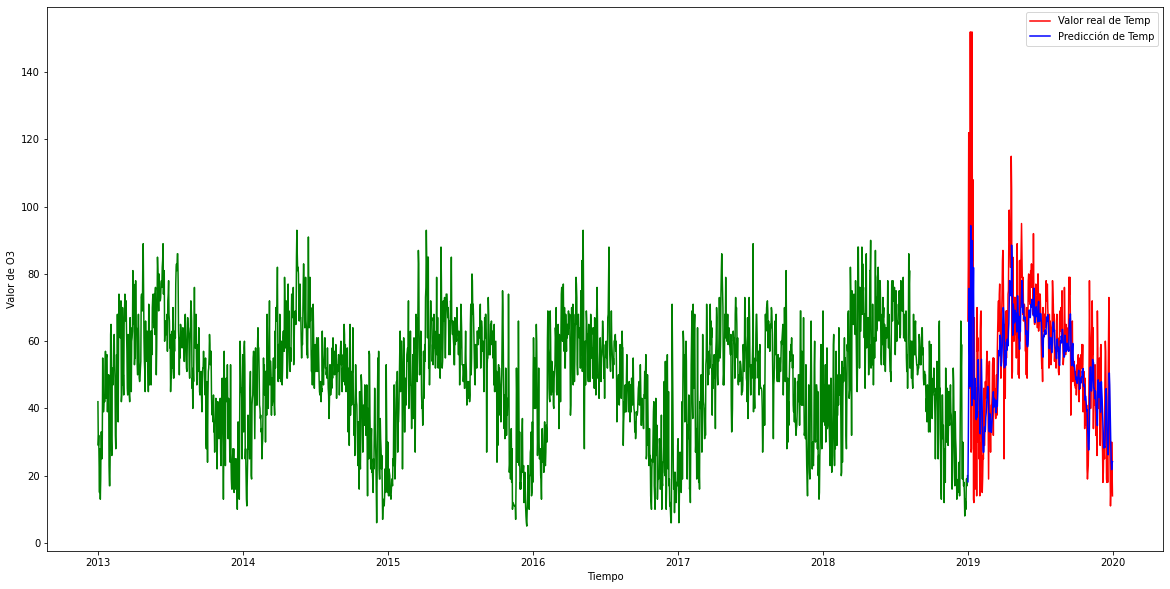

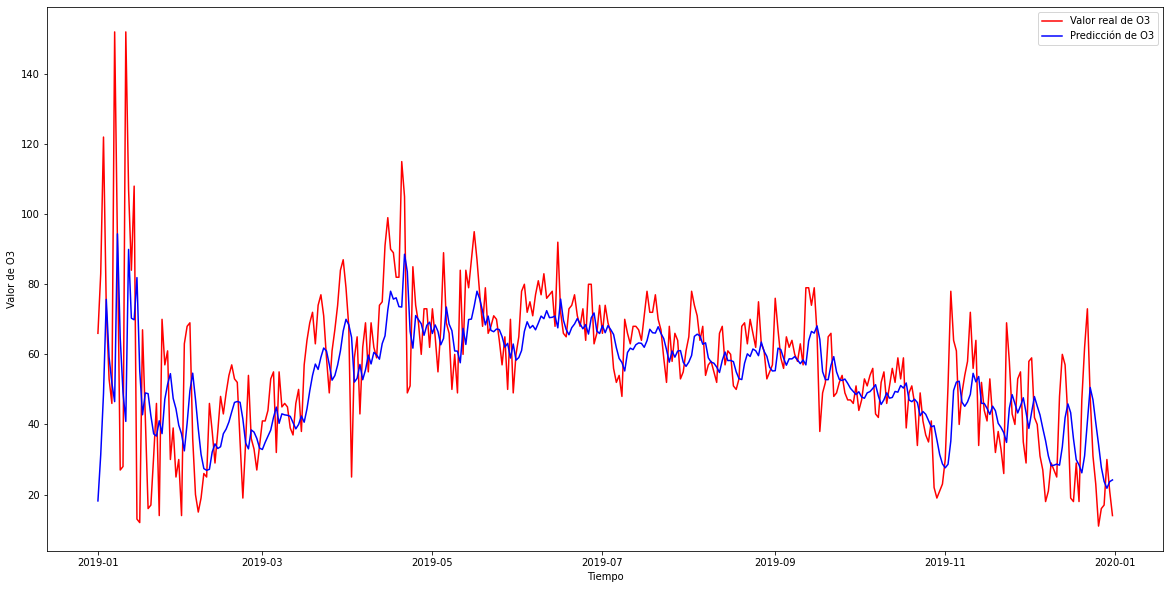

10.978217252966475
Procesando estacion 46250048 VALÈNCIA  MOLÍ DEL SOL
Procesando atributo O3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  app.launch_new_instance()


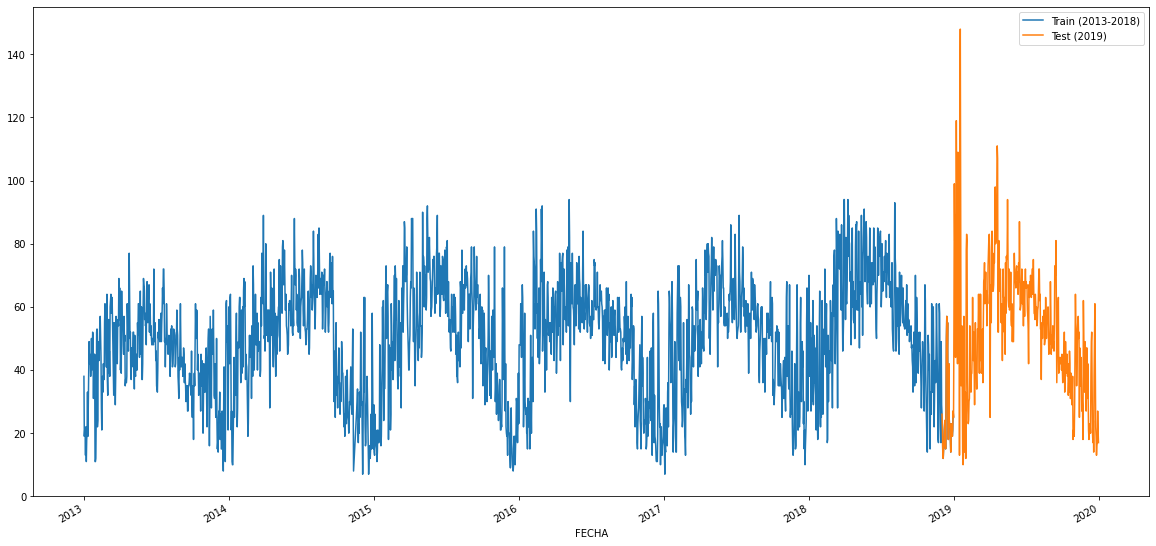

Epoch 1/50
68/68 [==============================] - 15s 88ms/step - loss: 0.0453
Epoch 2/50
68/68 [==============================] - 6s 90ms/step - loss: 0.0272
Epoch 3/50
68/68 [==============================] - 6s 92ms/step - loss: 0.0266
Epoch 4/50
68/68 [==============================] - 6s 89ms/step - loss: 0.0261
Epoch 5/50
68/68 [==============================] - 6s 84ms/step - loss: 0.0261
Epoch 6/50
68/68 [==============================] - 6s 85ms/step - loss: 0.0255
Epoch 7/50
68/68 [==============================] - 6s 85ms/step - loss: 0.0246
Epoch 8/50
68/68 [==============================] - 6s 87ms/step - loss: 0.0248
Epoch 9/50
68/68 [==============================] - 6s 86ms/step - loss: 0.0244
Epoch 10/50
68/68 [==============================] - 6s 87ms/step - loss: 0.0241
Epoch 11/50
68/68 [==============================] - 6s 87ms/step - loss: 0.0236
Epoch 12/50
68/68 [==============================] - 6s 83ms/step - loss: 0.0225
Epoch 13/50
68/68 [=================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


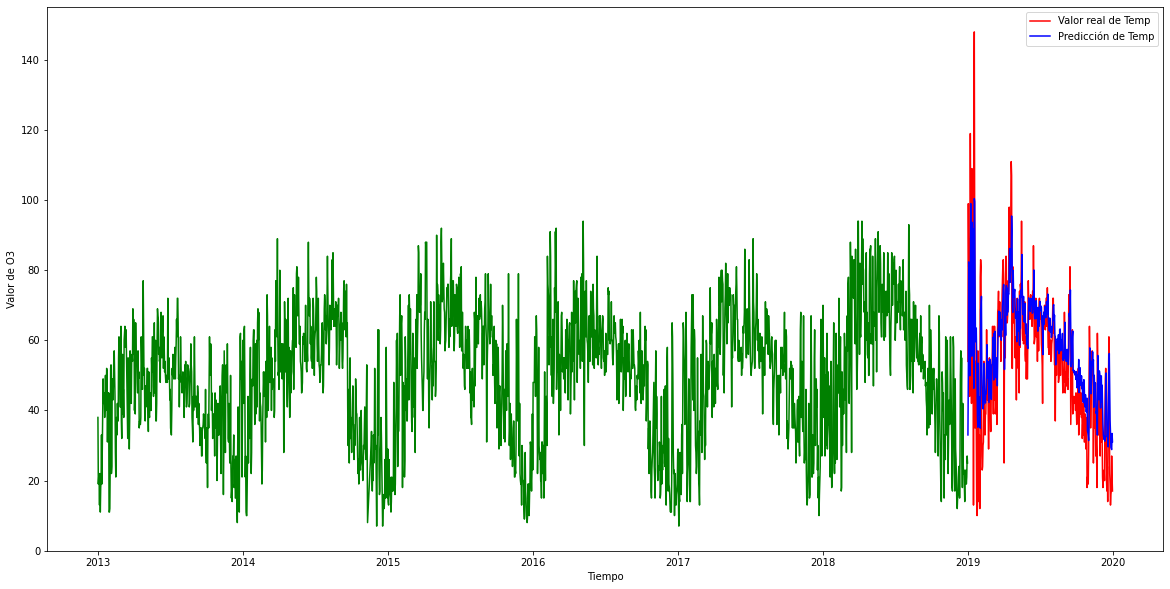

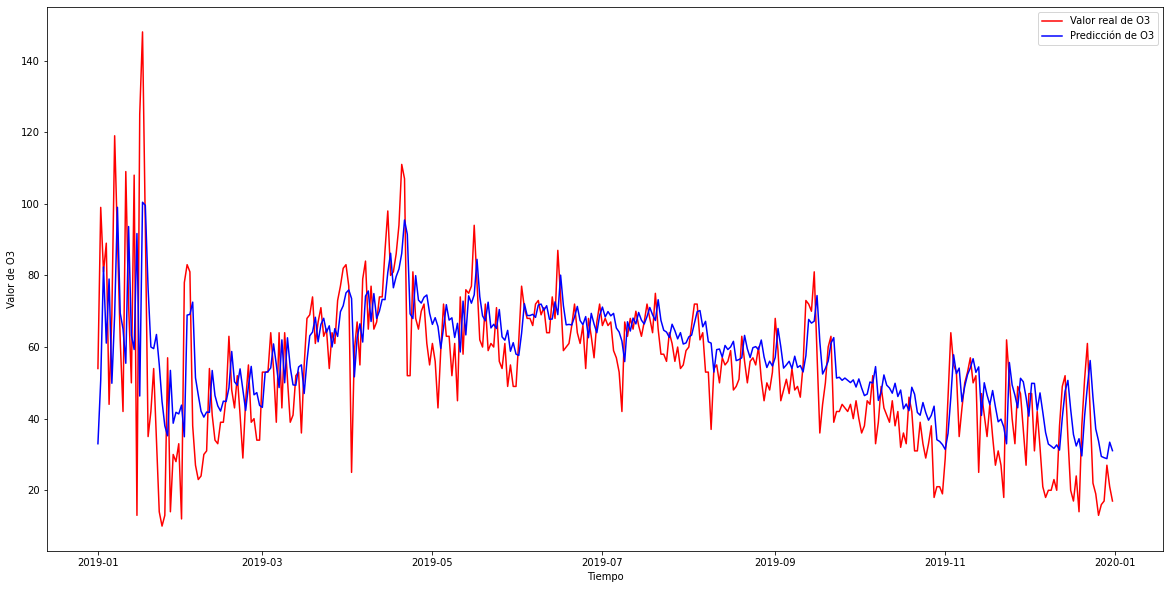

10.860053274076279


In [15]:
# Proceso principal

print(dfCompleto['COD_ESTACION'].unique())
print(dfCompleto['NOM_ESTACION'].unique())
cod_estaciones = dfCompleto['COD_ESTACION'].unique()
nom_estaciones = dfCompleto['NOM_ESTACION'].unique()
for i, nombre in zip(cod_estaciones, nom_estaciones):
  procesar_estacion(i, nombre, dfCompleto)